In [1]:
from sklearn.datasets import make_classification

# Generate a 2-class classification dataset with 5 features and 200 instances
X, y = make_classification(n_samples=200, n_features=20, n_informative=1, n_redundant=0, n_clusters_per_class=1, n_classes=2, random_state=0)

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LogisticRegression(random_state=0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=0)

In [4]:
import interrogation_analysis

In [5]:
from AITIA.uncertainty_system import UncertaintyEstimator

In [6]:
ue = UncertaintyEstimator(model)
ue.fit(X,y)

In [7]:
x_train, x_shap = interrogation_analysis.explain_meta_features(ue, X, y, X[:100,:], M=10)

Explaining Instances: 100%|██████████| 100/100 [00:02<00:00, 34.06instance/s]


In [66]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import zscore

def bee_swarm_plot(X_train, X_shap, feature_names):
    # Create a DataFrame for the data
    data = pd.DataFrame(X_train, columns=feature_names)
    for col in data.columns:
        data[col] =  zscore(data[col])

    for col in data.columns:
        data[col] = (data[col] - data[col].min()) / (data[col].max() - data[col].min())


    # Create a DataFrame for the Shapley values
    shap_df = pd.DataFrame(X_shap, columns=feature_names)

    # Calculate mean absolute Shapley values for each feature
    mean_abs_shap_values = shap_df.abs().mean()

    # Sort feature names based on mean absolute Shapley values
    sorted_feature_names = mean_abs_shap_values.sort_values(ascending=False).index

    # Melt both DataFrames to long format
    data_melted = pd.melt(data, var_name='feature', value_name='feature_value')
    shap_melted = pd.melt(shap_df, var_name='feature', value_name='shap_value')

    # Combine the feature values and Shapley values
    combined_data = pd.concat([data_melted, shap_melted['shap_value']], axis=1)

    # Increase the space between y-ticks
    plt.figure(figsize=(12, 1.5 * len(feature_names)))

    # Create a horizontal bee swarm plot with no legend, using the sorted feature order
    ax = sns.swarmplot(
        x='shap_value', y='feature', hue='feature_value',
        data=combined_data, palette=sns.color_palette("coolwarm", as_cmap=True),
        order=sorted_feature_names, orient='h', size=8, legend=False
    )

    # Add a vertical line at x=0
    ax.axvline(x=0, color='black', linestyle='--', linewidth=1)

    # Add a vertical color bar to the right
    sm = plt.cm.ScalarMappable(cmap=sns.color_palette("coolwarm", as_cmap=True))
    sm.set_clim(vmin=0, vmax=1)
    cbar = plt.colorbar(sm, ax=ax, orientation='vertical', pad=0.05)
    cbar.set_label('Feature Value')

    # Customize color bar ticks and labels
    cbar.set_ticks([0, 1])
    cbar.set_ticklabels(['Low', 'High'])

    plt.xlabel('SHAP value (impact on model output)')
    ax.set_ylabel('') 

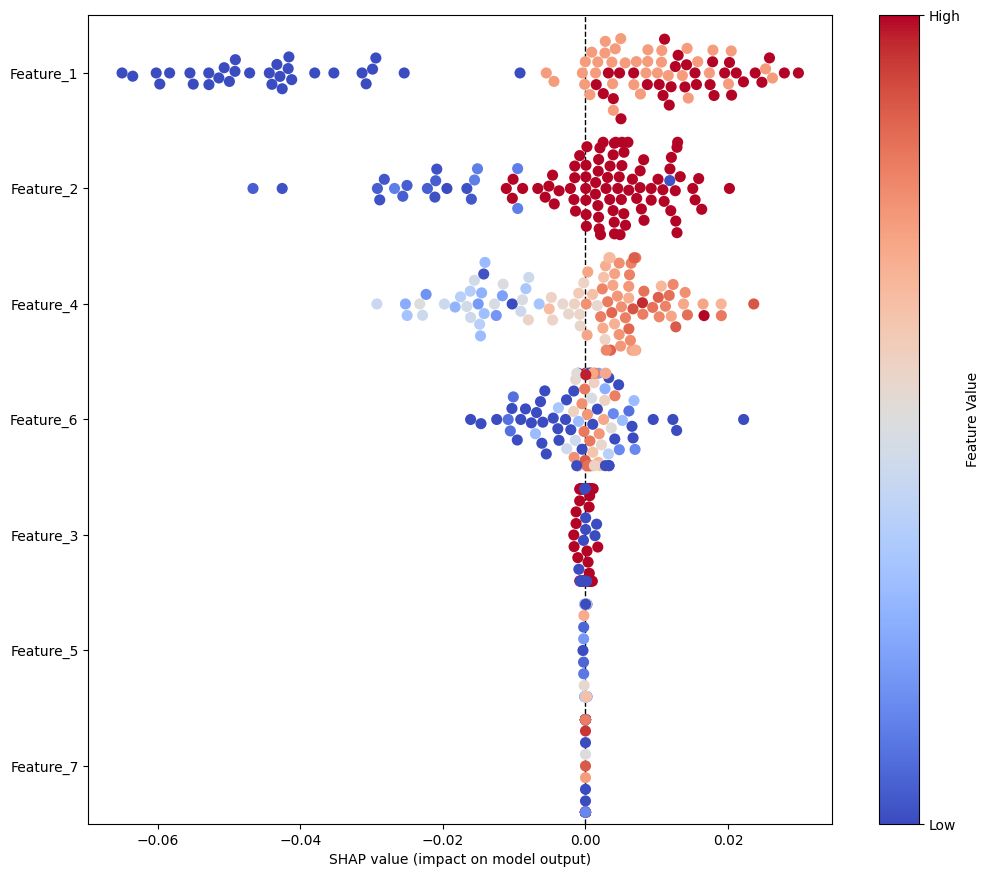

In [67]:
import numpy as np

# Set random seed for reproducibility
np.random.seed(42)

# Number of instances and features
num_instances = 100

# Generate synthetic data (X_train)
X_train = x_train

# Generate synthetic Shapley values (X_train_shap)
X_train_shap = np.array(x_shap)

# Feature names
feature_names = [f'Feature_{i}' for i in range(1, X_train_shap.shape[1] + 1)]

# Example usage of the bee_swarm_plot function
bee_swarm_plot(X_train, X_train_shap, feature_names)